## Generating the Data

In [37]:
from sklearn import datasets
import math

def get_train_test_data(n=100, seed=11121):
    # Generate all data
    data_all = datasets.make_moons(n, random_state=seed)[0]

    # Split into train/test data
    train_n = math.floor(0.8 * n)
    train_data = data_all[:train_n]
    test_data = data_all[train_n:]

    return train_data, test_data


train_data, test_data = get_train_test_data()

## Define the Gaussian PDF

For a point $ x $, the PDF for a multivariate Gaussian distribution is:
$$
   p(x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$
This formula includes:
   - $ |\Sigma| $: Determinant of the covariance matrix.
   - $ \Sigma^{-1} $: Inverse of the covariance matrix.
   - Exponential term based on the squared distance between $ x $ and $ \mu $.

as found on [Wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)


The Single Gaussian Model assumes the data follows a Gaussian distribution with these parameters. Since the actual data distribution is not Gaussian, this model will only be an approximation.

In [38]:
import numpy as np

def calculate_mean_and_covariance(data):
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def gaussian_pdf(x, mean, covariance):
    d = len(mean)
    det_covariance = np.linalg.det(covariance)
    inv_covariance = np.linalg.inv(covariance)
    norm_factor = 1 / ((2 * np.pi) ** (d / 2) * det_covariance ** 0.5)
    
    diff = x - mean
    exponent = -0.5 * np.dot(np.dot(diff.T, inv_covariance), diff)
    
    return norm_factor * np.exp(exponent)

def sample_gaussian(mean, covariance, n=1):
    z = np.random.normal(size=(n, len(mean)))
    
    # Step 2: Transform the samples to match the Gaussian distribution
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    Lambda_sqrt = np.diag(np.sqrt(eigenvalues))
    
    transformed_samples = z @ Lambda_sqrt @ eigenvectors.T + mean
    
    return transformed_samples

Fit the Gaussian model to the training data

In [39]:
mean, covariance = calculate_mean_and_covariance(train_data)

Step 4: Calculate PDF values for the test data

In [40]:
pdf_values = np.array([gaussian_pdf(x, mean, covariance) for x in test_data])
print("PDF Values for test data:", pdf_values)

PDF Values for test data: [0.06713966 0.33354142 0.20734088 0.15582192 0.1250835  0.33510163
 0.14854285 0.33189497 0.13464797 0.13375654 0.12249926 0.12609558
 0.14078176 0.14989737 0.1750712  0.33819156 0.14379697 0.1318044
 0.26489754 0.33749538]


### Plotting

In [41]:
import matplotlib.pyplot as plt

# Define grid over the data range for contour plot
x_min, x_max = train_data[:, 0].min() - 1, train_data[:, 0].max() + 1
y_min, y_max = train_data[:, 1].min() - 1, train_data[:, 1].max() + 1
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Calculate PDF values over the grid for the contour plot
pdf_values = np.array([
    gaussian_pdf(np.array([x, y]), mean, covariance)
    for x, y in zip(np.ravel(x_grid), np.ravel(y_grid))
])
pdf_values = pdf_values.reshape(x_grid.shape)

### Plot (i): Density as contour plot

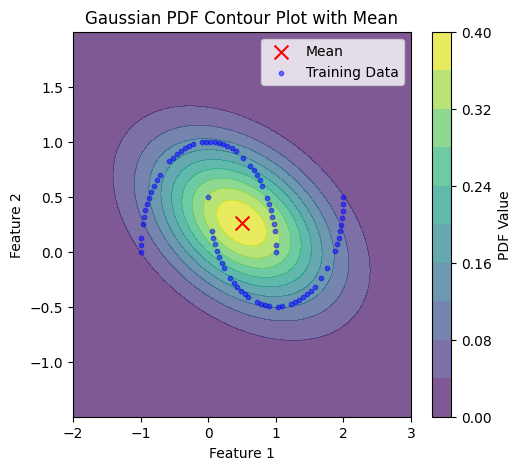

In [42]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(x_grid, y_grid, pdf_values, levels=10, cmap="viridis", alpha=0.7)
plt.colorbar(label="PDF Value")
plt.scatter(mean[0], mean[1], color="red", marker="x", s=100, label="Mean")
plt.scatter(train_data[:, 0], train_data[:, 1], color="blue", s=10, alpha=0.5, label="Training Data")
plt.title("Gaussian PDF Contour Plot with Mean")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

### Plot (ii): Generate and plot synthetic dataset from Gaussian

NEed to generate new samples from the fitted Gaussian model, based on the mean and covariance derived training data, to visualize what the Single Gaussian model predicts the data looks like

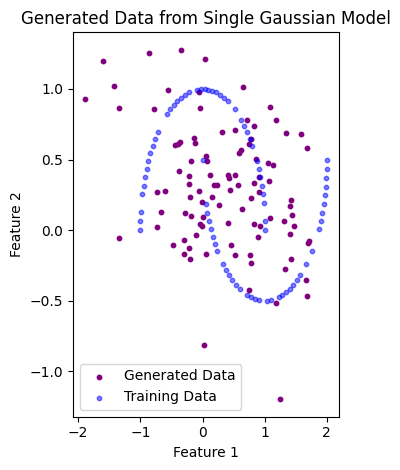

In [43]:
generated_data = sample_gaussian(mean, covariance, n=100)

plt.subplot(1, 2, 2)
plt.scatter(generated_data[:, 0], generated_data[:, 1], color="purple", s=10, label="Generated Data")
plt.scatter(train_data[:, 0], train_data[:, 1], color="blue", s=10, alpha=0.5, label="Training Data")
plt.title("Generated Data from Single Gaussian Model")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

### Strengths
- **Simplicity and Efficiency**: The Single Gaussian model is computationally efficient (this notebook runs fast) and easy to implement (only one function is needed essentially)
- **Distribution Approximation**: For data that is roughly unimodal and symmetric, the Gaussian is a decent approximation


### Weaknesses
- **Inflexibility for Complex Shapes**: The Single Gaussian model is limited to a single peak and fails to capture multimodal or non-linear distributions, such as the "moons" data, which has a distinct shape.
- **Poor Fit for Non-Gaussian Data**: It assumes that data is symmetrically distributed around a mean, making it unsuitable for datasets with clusters or irregular shapes, leading to an inaccurate representation.

We clearly see that the model is not appropriate for this. However, we can use this as a reference  for comparing more complex models and to see improvements or limitations when using other methods like GMM or KDE.

## MMD Evaluation

In [44]:
from MMD.MMD import calculate_mmd

reference_data = test_data

# Calculate MMD between generated samples and reference test data
mmd_results = calculate_mmd(reference_data, generated_data, bandwidths=[1.0, 2.0])

for kernel, mmd_value in mmd_results.items():
    print(f"MMD using {kernel} kernel: {mmd_value}")

MMD using squared_exponential kernel: 0.006972829042178219
MMD using inverse_multiquadratic kernel: 0.009887928447320116
